<a href="https://colab.research.google.com/github/sayan0506/Deep-Learning-CV-Hackathon/blob/main/Face_Verification_Based_Attendance_System_using_Arcface_Transfer_Learning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Verification using Arcface, Siamese network training using triplet loss**

## **Import Dependencies**

In [1]:
import zipfile
import os
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd
import numpy as np

import torch

# **Environment Setup**

#### **Check GPU utilization**

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [3]:
print(f'Device info\n{torch.cuda.get_device_properties(0)}')

Device info
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


## **Drive mount**

In [4]:
# drive mount
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## **Data Load**

#### Unzipping

Defining the unzipping function

In [5]:
# unzip function
def unzip_file(src, dst):
  # create a destination folder if not exists
  if not os.path.isdir(dst):
    os.mkdir(dst)
  print(f'The unzipped files will be stored to "{dst}" destination folder')

  with zipfile.ZipFile(src, 'r') as zip_ref:
    zip_ref.extractall(dst)

**Drive link: [face_train_set.zip](https://drive.google.com/file/d/1r5QjkBxspHILq1Bc_xpr7apbGWx1cmzy/view?usp=sharing)**

In [6]:
# zip path(in drive) containing individual class folders
zip_filepath = '/content/drive/MyDrive/face_trainset/face_train_set.zip'

# destination face trainset folder
dst_path = 'face_trainset'

**Unzipping**

In [7]:
unzip_file(zip_filepath, dst_path)

The unzipped files will be stored to "face_trainset" destination folder


## **Data Analysis**

Note: It's checked that, there is no .dstore or other files in the dataset folder, so each of the folder corresponds to uniquee identity, thus total list of directories equals to total identities.

In [8]:
face_dataset_path = "/content/face_trainset/face_train_set"

#### Fetching image info corresponding to individual classes

Fetching image info to image dictionary. Key corresponds to individual class, and value for that class will be list of all the image ids

In [9]:
# image dictionary
img_dict = {}

# image counts
img_count = 0

for identity in os.listdir(face_dataset_path):
  path = os.path.join(face_dataset_path, identity)
  img_dict[identity] = os.listdir(path)
  img_count+= len(os.listdir(path))

#print(f'Image dictionary\n{img_dict}')

In [12]:
# classifiers list
classifiers = img_dict.keys()

print(f'Total {img_count} images available corresponds to {len(img_dict.keys())} identities')

Total 4419 images available corresponds to 1012 identities


**To prepare the dataset, we need to first extract the faces to prepare face dataset for the identities, which needs an efficient face-detector.**

## **Face Extraction Test check**

For face detection in the images we are using pre-trained Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks.

[Reference paper](https://arxiv.org/abs/1604.02878) 

Git clone facenet_pytorch, which consists MTCNN face detector

[Git Repo](https://github.com/timesler/facenet-pytorch)

In [13]:
!git clone https://github.com/timesler/facenet-pytorch.git

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1264, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 1264 (delta 11), reused 7 (delta 2), pack-reused 1235
Receiving objects: 100% (1264/1264), 22.89 MiB | 46.14 MiB/s, done.
Resolving deltas: 100% (613/613), done.


**Rename folder to "facenet_pytorch", as python module import does not accept module name which consists of "-" character.**

In [14]:
os.rename('facenet-pytorch','facenet_pytorch')

In [15]:
# change directory
#%cd /content/facenet_pytorch

#### **Import Dependencies for MTCNN face detector**

In [16]:
from facenet_pytorch.models.mtcnn import MTCNN
from facenet_pytorch.models.inception_resnet_v1 import InceptionResnetV1


#### **Define MTCNN module**

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See help(MTCNN) for more details.

In [17]:
# face detector object
# using default reshaped face size = (160,160)
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### **Perform MTCNN Facial detection check**

For testing we are checking with a class id, where multiple faces are present along with target id(the one with "script" in it's name)

**Class id: "0014_0002560"**

In [18]:
class_id = "0014_0002560"
# class path
class_path = os.path.join(face_dataset_path, class_id)

# image samples count for that class
img_c = len(os.listdir(class_path))

**Perform and visualize the detected faces in the image samples**

In [19]:
tracked_faces = []

for i, sample in enumerate(os.listdir(class_path)):

  # read using PIL library, else ImagDraw will not work here
  img = Image.open(os.path.join(class_path, sample))
  
  # detect faces
  boxes, _ = mtcnn.detect(img)

  # draw faces
  img_draw = img.copy()
  
  # define draw object to draw on the image
  draw = ImageDraw.Draw(img_draw)
  for box in boxes:
    draw.rectangle(box.tolist(), outline = (255,0,0), width = 4)
  print(f'face count in the sample {i} is {len(boxes)}')
  
  # add image to aligned list
  tracked_faces.append(img_draw)
  #, Image.BICUBIC))

print('\nDone Detection')

face count in the sample 0 is 1
face count in the sample 1 is 1
face count in the sample 2 is 7

Done Detection


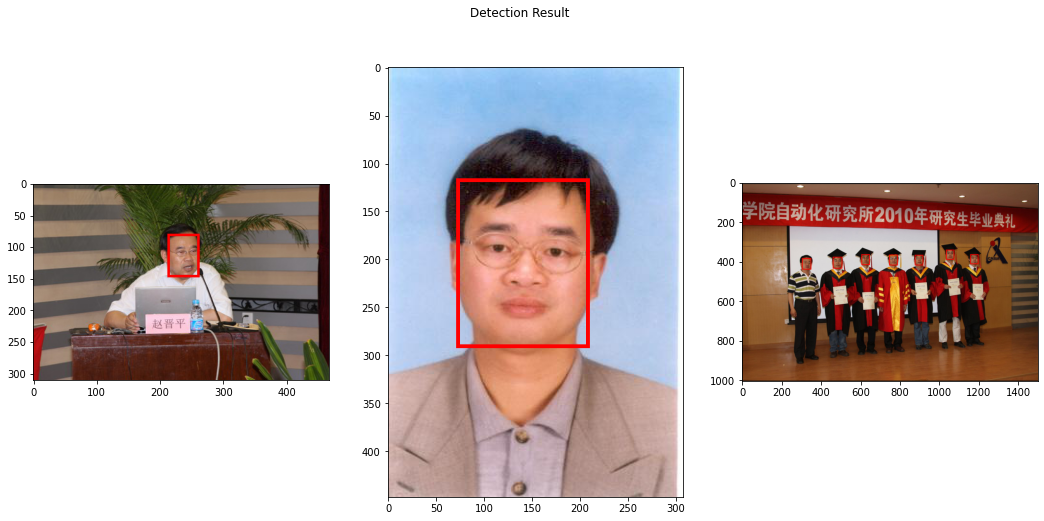

In [20]:
fig = plt.figure(figsize = (18,8))
fig.tight_layout()
fig.suptitle('Detection Result')

for i, img_sample in enumerate(tracked_faces):
  fig.add_subplot(1, img_c, i+1)
  plt.imshow(img_sample)

plt.show()

#### **Demo cropped Face**

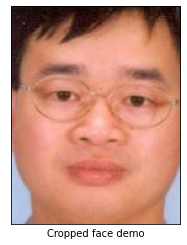

In [22]:
# sample image open
img = Image.open(os.path.join(class_path, os.listdir(class_path)[1]))

# detect faces
boxes, _ = mtcnn.detect(img)

cropped_face = img.crop(boxes[0].tolist())

plt.imshow(cropped_face)
plt.xlabel('Cropped face demo')
plt.xticks([])
plt.yticks([])

plt.show()

## **Implement face checking during face Extraction for data Preperation**

Implementing face checking with the anchor image(whose name consists of "script") when there are multiple images are present along with further manual inspection. As, we can't completely rely on this, aas we are going to build more finetuned algo, and the facenet has no previous knowledge of the input face, but this speeds up the trainset or facebank creation process.

#### **Define inception Resnet V1 module**

Inception Resnet V1 introduces the advantage of both inception and resnet together(have two sub-versions- V1, V2)

[Reference](https://ai.googleblog.com/2016/08/improving-inception-and-image.html)

Set classify = True for the pretrained classifier. For this case we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to eval mode.

In [23]:
# load the pretrained model trained on "vggface2" to the GPU
resnet = InceptionResnetV1(pretrained = 'vggface2').eval().to(device)

**Face extractor function**

In [24]:
def face_extract(img_path):
  # loads the list of extracted faces
  faces = []
  # sample image open
  img = Image.open(img_path)

  # detect faces with confidences
  boxes, p = mtcnn.detect(img)
  # faces with confidence greater than 96 ercent are considered here
  boxes = boxes[np.where(p>0.96)]
  
  for box in boxes:
    faces.append(img.crop(box.tolist()))

  return faces

**Demo face extraction**

In [26]:
# the image which has the "script" in it's name, the passport size image
anchor_image_path = os.path.join(class_path, os.listdir(class_path)[1])

# multiple face image
faces_image_path = os.path.join(class_path, os.listdir(class_path)[2])

# stores the faces
faces_demo = []

# getching faces
faces_demo = face_extract(faces_image_path)
anchor_demo = face_extract(anchor_image_path)

print(f'Total {len(faces_demo)} faces are there along with the anchor face in the multiface image')

Total 7 faces are there along with the anchor face in the multiface image


**Face visualization**

7


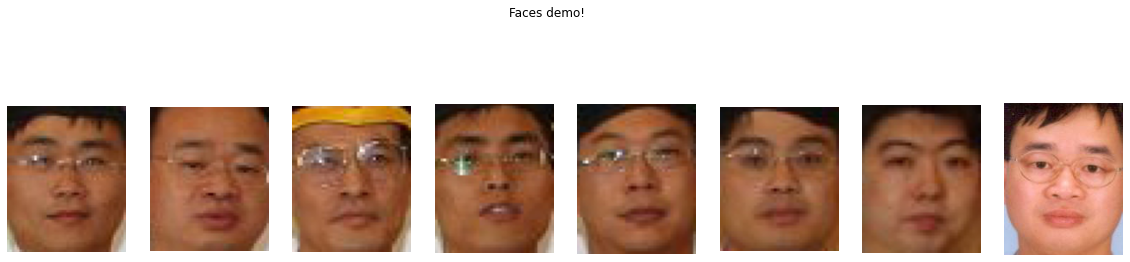

In [27]:
fig = plt.figure(figsize = (20,5))
fig.suptitle('Faces demo!')
fig.tight_layout()

face_count = len(faces_demo) + len(anchor_demo)
print(len(faces_demo))

for i, face in enumerate(faces_demo):
  fig.add_subplot(1, face_count, i+1)
  plt.imshow(face)
  plt.axis('off')

fig.add_subplot(1, face_count, i+2)
plt.imshow(anchor_demo[0])
plt.axis('off')

plt.show()

#### **Obtain aligned faces list for the demo images using MTCNN**

In [28]:
# append the anchor image at the end of face_demo, thus [-1]th index is the anchor image
faces_demo.append(anchor_demo[0])

In [29]:
# stores the list of aligned faces
aligned = []
#names = []
for face in faces_demo:
    x_aligned, prob = mtcnn(face, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        #names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999964
Face detected with probability: 0.999820
Face detected with probability: 0.999912
Face detected with probability: 0.999992
Face detected with probability: 0.999936
Face detected with probability: 0.999994
Face detected with probability: 0.999874
Face detected with probability: 0.999992


**Demo aligned image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


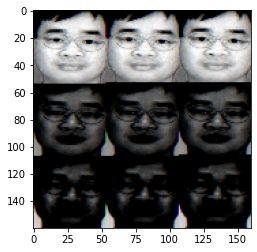

In [30]:
plt.imshow(aligned[-1].reshape(160,160,3))
plt.show()

#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it. 

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [31]:
# aligned torch tensor stack loaded in the gpu
aligned = torch.stack(aligned).to(device)
# obtain embeddings from the model loaded to gpu, and then reloaded to cpu after embeddings are obtained
embeddings = resnet(aligned).detach().cpu()

In [32]:
embeddings.shape

torch.Size([8, 512])

**Distance between the anchor and respective images**

In [33]:
# embedding of anchor image
anchor_embed = embeddings[-1]
# distance between the other images
dists = [(anchor_embed - embed).norm().item() for embed in embeddings[:-2]]

**The matched result is the minimum distance of the list of embedding distances**

In [34]:
# the index of that image 
matched_index = np.argmin(dists)
print(f'The face that matches the anchor is {matched_index}')

The face that matches the anchor is 1


Face matching result


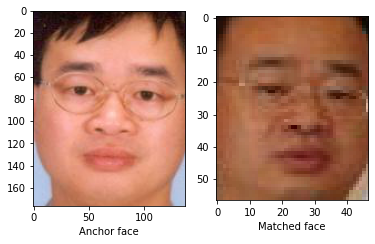

In [35]:
print('Face matching result')
plt.subplot(121)
plt.imshow(anchor_demo[0])
plt.xlabel('Anchor face')


plt.subplot(122)
plt.imshow(faces_demo[matched_index])
plt.xlabel('Matched face')

plt.show()

## **Build Face Database**

**Define the funcion to extract faces**

In [36]:
def face_extract(img_path):
  # loads the list of extracted faces
  faces = []
  # sample image open
  # converts to 'RGB' to ensure all the images fed to MTCNN are of 3 channels(R,G,B)
  img = Image.open(img_path).convert('RGB')

  # detect faces with confidence
  boxes, p = mtcnn.detect(img)
  # extract boxes containing faces whose confidence greater than 96%(0.96)
  boxes = np.array(boxes[np.where(p>0.96)])
  
  for box in boxes:
    faces.append(img.crop(box.tolist()))

  return faces

**Build a facebank, containing the extracted faces corresponsing to the samples of individual class** 

In [37]:
# create facebank
face_dir = 'facebank'

# create directory
if not os.path.isdir(face_dir):
  os.mkdir(face_dir)

print(f'Extracted faces will be stored in the folder "{face_dir}"')

Extracted faces will be stored in the folder "facebank"


**Defining the source and destination for facebank creation**

In [38]:
class_id = '0013_0002303'

In [39]:
#identities = []
#identities.append(class_id)

identities = img_dict.keys()
print(f'Total {len(identities)} unique folders will be created corresponds to unique identities')

# face_trainset path as source path
src_path = face_dataset_path

# destination path as facebank path
dst_path = face_dir

Total 1012 unique folders will be created corresponds to unique identities


##### **Create the Facebank**

* Extracting the faces from individual sample corresponding to each identity folder
* If a single face is found in a sample
* If that image name consists of "script" keyword, treat that face as anchor image, whose destination name will be "class_id_script", else "class_id_img_serial_no"

**Define the function which matches the anchor image with the list of extracted faces when multiple faces are present**

In [40]:
def multiface_check(faces_demo):
  # stores the list of aligned faces
  aligned = []
  #names = []
  #print(len(faces_demo))
  for face in faces_demo:
      # consider that extracted face whose width>=20
      if face.size[0]>20:
        x_aligned, prob = mtcnn(face, return_prob=True)
        #print(f'aligned-{x_aligned}')
        if x_aligned is not None:
            aligned.append(x_aligned)

  #print(f'aligned_count-{len(aligned)}')  
  # aligned torch tensor stack loaded in the gpu
  if len(aligned)>1:
    aligned = torch.stack(aligned).to(device)
    #print(aligned.shape)
    # obtain embeddings from the model loaded to gpu, and then reloaded to cpu after embeddings are obtained
    embeddings = resnet(aligned).detach().cpu()
    # embedding of anchor image
    anchor_embed = embeddings[-1]
    # distance between the other images
    dists = [(anchor_embed - embed).norm().item() for embed in embeddings[:-1]]

    # threshold is taken as 0.8
    threshold = 1.5
    #print(dists)
    if min(dists)<threshold:
      # the index of that image which closely macthes with anchor
      matched_index = np.argmin(dists)
      return matched_index
  
  else:
    matched_index = None

  

In [41]:
# counts images which contain multiple faces
multiface_image_count = 0
# counts images which contain multiple faces where a match is found with the anchor
multiface_matched_image_count = 0


for id in identities:
  #print(f'identity-{id}')
  # detination folder path for the id in facebank
  id_dst_path = os.path.join(dst_path, id)
  if not os.path.isdir(id_dst_path):
    os.mkdir(id_dst_path)

  id_src_path = os.path.join(src_path, id)
  # fetch image list
  sample_list = os.listdir(id_src_path)
  
  # count starts from 0 in destination id folder
  id_count = 0
  
  # ensures the flag = 1 for multiple face present in an image
  multiface_flag = 0
  multiface_all = []
  # list of multiple faces
  multiface_list = []

  # script flag ensures whether multiple passport size images are there or not
  script_flag = 0

  for i, id_img in enumerate(sample_list):
    #print(f'img_id-{id_img}')
    id_img_path = os.path.join(id_src_path, id_img)
    # extract faces
    face_imgs = face_extract(id_img_path)

    if face_imgs!=None:
     # single face is found in the sample
     if len(face_imgs)==1:
       # checks whether the image name contains "script" or not
       if id_img.find("script")>0 and script_flag ==0:
         # make script flag to 1 to ensure one passport or anchor image is found, skip to next
         script_flag = 1
         anchor_face = face_imgs[0]
         # image destination name "class_id_script"
         img_id_dst_name = f'{id}_script'

       else:
          # image destination name "class_id_serial number"
          img_id_dst_name = f'{id}_{i}'
       img_dst_id_path = os.path.join(id_dst_path, img_id_dst_name)+'.jpg' 
       face_imgs[0].save(img_dst_id_path)

     # if more than one image is found
     else:
       #print(f'img_id-{id_img}')
       multiface_flag = 1
       # appends list of face images for that smple to the multiface list
       # for multiple multiface samples multiple lists will be appended
       multiface_list = face_imgs
       multiface_all.append(multiface_list)
       multiface_image_count += 1 


  if multiface_flag:
    #print(len(multiface_all))
    for c, mf_image in enumerate(multiface_all):
      #current_mf_list = []
      # appends anchor image to the list
      mf_image.append(anchor_face)
      # returns matched face index
      #print(f'mf-{mf_image}')
      face_idx = multiface_check(mf_image)
      #print(f'idx-{face_idx}')

      # face is not extracted with effective confidence(<thresold)
      if face_idx is not None:
        img_id_dst_name = f'{id}_{i+c}'
        img_dst_id_path = os.path.join(id_dst_path, img_id_dst_name)+'.jpg' 
        mf_image[face_idx].save(img_dst_id_path)
        multiface_matched_image_count += 1


print('Face extraction is done for the identities')

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


Face extraction is done for the identities


**Face Extrction Analysis**

We have to do several trial and errors to setup the face extraction procesure, so as to ensure there are atleast 2 images available corresponding to each identity in the facebank

In [ ]:
# counts total folders or identities available in the facebank
identity_count = len(os.listdir('facebank'))

# counts total faces in the facebank
facebank_count = 0

for i in os.listdir('facebank'):
  if len(os.listdir(os.path.join('facebank',i)))<2:
    # prints the classes where there is less than 2 face images available
    print(i)
  facebank_count+=len(os.listdir(os.path.join('facebank',i)))

print(f'Total {facebank_count} facial images available corresponding to {identity_count}')

Total 4279 facial images available corresponding to 1012
